# Bond Cashflows

This notebook demonstrates how to access and use the **Bond** functionalities within the **LSEG Financial Analytics SDK**. 

Bond instruments are fixed income securities that represent debt obligations. Bond types supported:
- Fixed Rate Bonds: Bonds with fixed coupon payments over the life of the bond
- Floating Rate Bonds: Bonds with variable coupon rates tied to reference rates (SOFR, LIBOR, etc.)
- Zero Coupon Bonds: Bonds that pay no periodic interest, sold at discount to face value
- Inflation-Linked Bonds: Bonds with principal and/or coupons adjusted for inflation
- Callable/Puttable Bonds: Bonds with embedded options for early redemption

**You will be able to:**
- Extract and analyze detailed bond cashflow schedules
- Visualize cashflows with interactive charts and tables

## Imports

Import the following necessary modules:

- `lseg_analytics.pricing.instruments.bond` - for Bond instrument definitions and analytics

This notebook uses external libraries **pandas, IPython, matplotlib**; please ensure they are installed in your Python environment (e.g. 'pip install pandas') before running the code.

In [1]:
from lseg_analytics.pricing.instruments import bond   as bd

import pandas as pd
import json
import datetime as dt
from IPython.display import display
import matplotlib.pyplot as plt

## Data Preparation

To define a Bond instrument you need to follow a structured 3-step process:

1. **Bond Definition** - Specify basic bond parameters (coupon rate, maturity date, face value, payment frequency)
2. **Bond Instrument Definition** - Create the instrument object for pricing
3. **Pricing Preferences** - Configure pricing parameters and market data settings

**Cashflow Structure Types:**
- **Vanilla Payment**: Equal coupon amounts throughout the life, Single principal payment at maturity
- **Amortizing**: Principal payments throughout the life
- **Amortizing - user defined**: user defined amortization schedule

## 

In [2]:
print("Step 1: Creating Fixed Rate Bond Definitions for Cashflow Analysis...")
print("=" * 70)

# Base Bond Parameters (Common to all scenarios)
BASE_PARAMS = {
    'notional_amount': 1_000_000,                              # $1M face value
    'notional_ccy': "USD",                                     # USD denomination
    'fixed_rate_percent': 5.00,                                # 5.00% annual coupon
    'interest_type': bd.InterestTypeEnum.FIXED,                # Fixed rate
    'issue_date': dt.datetime(2023, 1, 15),                    # Issue date
    'end_date': dt.datetime(2028, 1, 15),                      # 5-year maturity
    'interest_payment_frequency': bd.InterestPaymentFrequencyEnum.SEMI_ANNUAL,  # Coupons paid every 6M
    'first_regular_payment_date': dt.datetime(2023, 7, 15),    # First coupon in July
    'interest_calculation_method': bd.InterestCalculationMethodEnum.DCB_30_360,  # 30/360 interest day count basis
    'payment_business_day_convention': bd.PaymentBusinessDayConventionEnum.MODIFIED_FOLLOWING,  # Modified following Payment business day convention
    'payment_business_days': "USA"                             # US calendar
}

# =================================================

# Scenario 1: Vanilla Cashflow - Standard Bond with Bullet Repayment
print("\nScenario 1: Vanilla Cashflow - Standard Bond with Bullet Repayment")
bond_vanilla = bd.BondDefinition(
    **BASE_PARAMS,
    instrument_tag="BOND_VANILLA_5Y"
)

print(f"   Structure: Bullet bond with semi-annual coupons")
print(f"   Coupon: {bond_vanilla.fixed_rate_percent}% semi-annually")
print(f"   Expected Cashflows: 10 coupon payments + principal at maturity")
print(f"   Each Coupon: ${bond_vanilla.notional_amount * bond_vanilla.fixed_rate_percent / 200:,.0f}")

# =================================================

# Scenario 2: Amortizing Bond - Linear Principal Reduction
print("\nScenario 2: Amortizing Bond - Linear Principal Reduction")

# Linear amortization: $100k principal payment each period
linear_amortization = [
    bd.AmortizationItemDefinition(
        start_date=dt.datetime(2023, 1, 15),                   # Start of amortization
        end_date=dt.datetime(2028, 1, 15),                     # End of amortization
        amortization_frequency=bd.AmortizationFrequencyEnum.SEMI_ANNUAL,  # Every 6M coupon payment
        amortization_type=bd.IPAAmortizationTypeEnum.LINEAR,   # Linear reduction
        remaining_notional=0.0,                                # Fully amortized at maturity
        amount=100_000                                         # $100k principal payment each period
    )
]

bond_linear_amort = bd.BondDefinition(
    **BASE_PARAMS,
    amortization_schedule=linear_amortization,
    instrument_tag="BOND_LINEAR_AMORT_5Y"
)

print(f"   Structure: Linear amortization with declining interest base")
print(f"   Principal Payment: ${linear_amortization[0].amount:,.0f} per period")
print(f"   Expected Cashflows: 10 payments of interest + principal reduction")
print(f"   First Payment: ${linear_amortization[0].amount + (1_000_000 * 0.05 / 2):,.0f} (interest + principal)")
print(f"   Last Payment: ${linear_amortization[0].amount + (100_000 * 0.05 / 2):,.0f} (interest + principal)")

# =================================================

# Scenario 3: User-Defined Amortization Schedule 
print("\nScenario 3: User-Defined Amortization Schedule")

# Custom amortization: Different amounts in different periods
custom_amortization = [
    # Years 3-5: Accelerated amortization
    bd.AmortizationItemDefinition(
        start_date=dt.datetime(2025, 1, 15),
        end_date=dt.datetime(2028, 1, 15),                     # Last 3 years
        amortization_frequency=bd.AmortizationFrequencyEnum.SEMI_ANNUAL,
        amortization_type=bd.IPAAmortizationTypeEnum.SCHEDULE,
        amount=500_000                                         # $500,000 paid at the end of year 2
    )
]

bond_custom_amort = bd.BondDefinition(
    **BASE_PARAMS,
    amortization_schedule=custom_amortization,
    instrument_tag="BOND_CUSTOM_AMORT_5Y"
)

print(f"   Structure: Interest-only for 2 years, then accelerated amortization")
print(f"   Years 1-2 (except year 2 last payment): Interest only (${25_000:,.0f} per payment)")
print(f"   Year 2 Last payment: Principal (${500_000:,.0f} payment) + interest (${25_000:,.0f})")
print(f"   Years 3-5: Interest only (${12_500:,.0f} per payment)")
print(f"   Expected Cashflows: 9 interest-only + 1 amortizing payment with interest")

Step 1: Creating Fixed Rate Bond Definitions for Cashflow Analysis...

Scenario 1: Vanilla Cashflow - Standard Bond with Bullet Repayment
   Structure: Bullet bond with semi-annual coupons
   Coupon: 5.0% semi-annually
   Expected Cashflows: 10 coupon payments + principal at maturity
   Each Coupon: $25,000

Scenario 2: Amortizing Bond - Linear Principal Reduction
   Structure: Linear amortization with declining interest base
   Principal Payment: $100,000 per period
   Expected Cashflows: 10 payments of interest + principal reduction
   First Payment: $125,000 (interest + principal)
   Last Payment: $102,500 (interest + principal)

Scenario 3: User-Defined Amortization Schedule
   Structure: Interest-only for 2 years, then accelerated amortization
   Years 1-2 (except year 2 last payment): Interest only ($25,000 per payment)
   Year 2 Last payment: Principal ($500,000 payment) + interest ($25,000)
   Years 3-5: Interest only ($12,500 per payment)
   Expected Cashflows: 9 interest-only

In [3]:
print("Step 2: Creating Bond Instrument Object...")

# Create instrument containers for all bond scenarios

bond_instruments = [
    bd.BondDefinitionInstrument(definition=bond_vanilla),
    bd.BondDefinitionInstrument(definition=bond_linear_amort),
    bd.BondDefinitionInstrument(definition=bond_custom_amort)
]

print("   Bond instrument containers created for pricing")

Step 2: Creating Bond Instrument Object...
   Bond instrument containers created for pricing


In [4]:
print("Step 3: Configuring Pricing Parameters...")
pricing_params = bd.BondPricingParameters(
    valuation_date=dt.datetime(2023, 7, 18),                   # Pricing date (greater than bonds issuances and first cash-flow date => 9 Cash-flow dates)
)

print(f"   Valuation Date: {pricing_params.valuation_date.strftime('%Y-%m-%d')}")

Step 3: Configuring Pricing Parameters...
   Valuation Date: 2023-07-18


We select the below the following fields that are interesting for Bond pricing and cash-flows:

- **InstrumentTag**: Tag for identification
- **Notional currency**: Currency of the Bond
- **Market Value**: Present value of the Bond, it is also the **Dirty Price** of the bond
- **Report currency**: Currency of Bond valuation and metrics
- **Clean Price**: Bond price excluding accrued interest
- **Yield**: Yield to maturity of the Bond
- **Modified Duration**: Interest rate sensitivity measure
- **Convexity**: Second-order price sensitivity to yield changes
- **DV01**: Sensitivity of the market value to a 1bp parallel shift in the zero-coupon curve
- **Cash-flows**: detailed cash-flows schedule

In [5]:
basic_fields = "InstrumentTag, NotionalCcy, MarketValueInDealCcy, ReportCcy, MarketValueInReportCcy"
additional_fields = "cleanPricePercent, dirtyPricePercent, yieldPercent, ModifiedDuration, convexity, DV01Bp"
cashflow_fields = "CashFlows"
fields = basic_fields + "," + additional_fields + "," + cashflow_fields

## Request Execution

In [6]:
# Execute the calculation using the price() function
# The 'definitions' parameter accepts a list of instrument definitions for batch processing

try:
    response = bd.price(
        definitions=bond_instruments,
        pricing_preferences=pricing_params,
        fields=fields
    )

    # Display response structure information
    analytics_data = response['data']['analytics'][0]
    if analytics_data['error'] == {}:
        print("   Calculation successful!")
    else:
        print(f"   Pricing error: {analytics_data['error']}")
        
except Exception as e:
    print(f"   Calculation failed: {str(e)}")
    raise


   Pricing error: {'code': 'QPS-Pricer.3002', 'message': 'Market data error : No quotation available for Bond.'}


## Results Display

### Key Sections in the `response` JSON

 - **definitions**: Bond instrument setup (coupon rate, maturity date, notional amount, payment frequency), using the BondDefinition that we created.

 - **pricingPreferences**: Valuation date, price side (BID/ASK/MID/LAST), currency settings, settlement conventions.

 - **analytics**:
   - **tabularData**: Customizable list of analytics given in `fields` argument of price() function (`data`, `headers`, `statuses`)
   - **cashflows**: Detailed schedule of payments
   - **description**: Bond instrument summary and default fields used in the calculation
   - **nominalMeasures**: Main risk metrics calculated on Bond (`modifiedDuration`, `convexity`, `dv01Bp`)
   - **pricingAnalysis**: detailed price information on Bonds (`cleanPricePercent`, `dirtyPricePercent`, `yieldPercent`)
   - **valuation**: Detailed valuation of the Bond instru;ent with the below fields:
      - `MarketValueInDealCcy`: Present value of the Bond in deal currency
      - `MarketValueInReportCcy`: Present value of the Bond in report currency
   - **error**: Root cause of any issues, if encountered


We give below for the three deals the tabular data details, that include information on valuation and risk metrics. Cash-Flows are represented afterwards

### Valuation and Risk metrics

In [7]:
# Convert multi-bond analytics to DataFrame for better visualization
print("Multi-Bond Analytics Summary:")
columns = [item['name'] for item in response['data']['analytics'][0]['tabularData']['headers']]
response_data = [item['tabularData']['data'] for item in response['data']['analytics']]

response_df = pd.DataFrame(response_data, columns=columns)

# Set InstrumentTag as index for better readability
response_df.set_index('InstrumentTag', inplace=True)

# Round numerical values to 4 decimal places while keeping strings unchanged
response_df_rounded = response_df.copy()
response_df_rounded = response_df_rounded.drop('CashFlows', axis=1)
for col in response_df_rounded.columns:
    if response_df_rounded[col].dtype in ['float64', 'int64']:
        response_df_rounded[col] = response_df_rounded[col].round(4)

display(response_df_rounded.T)

Multi-Bond Analytics Summary:


InstrumentTag,BOND_VANILLA_5Y,BOND_LINEAR_AMORT_5Y,BOND_CUSTOM_AMORT_5Y
NotionalCcy,USD,USD,USD
MarketValueInDealCcy,None,None,None
ReportCcy,USD,USD,USD
MarketValueInReportCcy,None,None,None
CleanPricePercent,None,None,None
DirtyPricePercent,None,None,None
YieldPercent,None,None,None
ModifiedDuration,None,None,None
Convexity,None,None,None
DV01Bp,None,None,None


### Cash-Flows

In [8]:
# Prepare CF dataframes for display
# Reminder: valuation date is greater than bonds issuances and first cash-flow date => 9 Cash-flow dates are showed

bonds_cashflows_dict = {}
for bond_index in range(len(response_df_rounded)):

    cashflows_df = pd.DataFrame(response['data']['analytics'][bond_index]['cashflows']['cashFlows'][0]['payments'])
    

    for col in cashflows_df.columns:
        if cashflows_df[col].dtype in ['float64', 'int64']:
            cashflows_df[col] = cashflows_df[col].round(2)

    bonds_cashflows_dict[response_df_rounded.T.columns[bond_index]] = cashflows_df

display(bonds_cashflows_dict.keys())

dict_keys(['BOND_VANILLA_5Y', 'BOND_LINEAR_AMORT_5Y', 'BOND_CUSTOM_AMORT_5Y'])

#### Scenario 1 Cashflows: Vanilla bond

,date,amount,remainingNotional,currency,event,type,occurence
0,2024-01-16,24695.08,1000000.0,USD,Interest,Fixed,Future
1,2024-07-15,24695.08,1000000.0,USD,Interest,Fixed,Future
2,2025-01-15,24695.08,1000000.0,USD,Interest,Fixed,Future
3,2025-07-15,24695.08,1000000.0,USD,Interest,Fixed,Future
4,2026-01-15,24695.08,1000000.0,USD,Interest,Fixed,Future
5,2026-07-15,24695.08,1000000.0,USD,Interest,Fixed,Future
6,2027-01-15,24695.08,1000000.0,USD,Interest,Fixed,Future
7,2027-07-15,24695.08,1000000.0,USD,Interest,Fixed,Future
8,2028-01-18,24695.08,0.0,USD,Interest,Fixed,Future
9,2028-01-18,1000000.00,0.0,USD,Principal,Fixed,Future


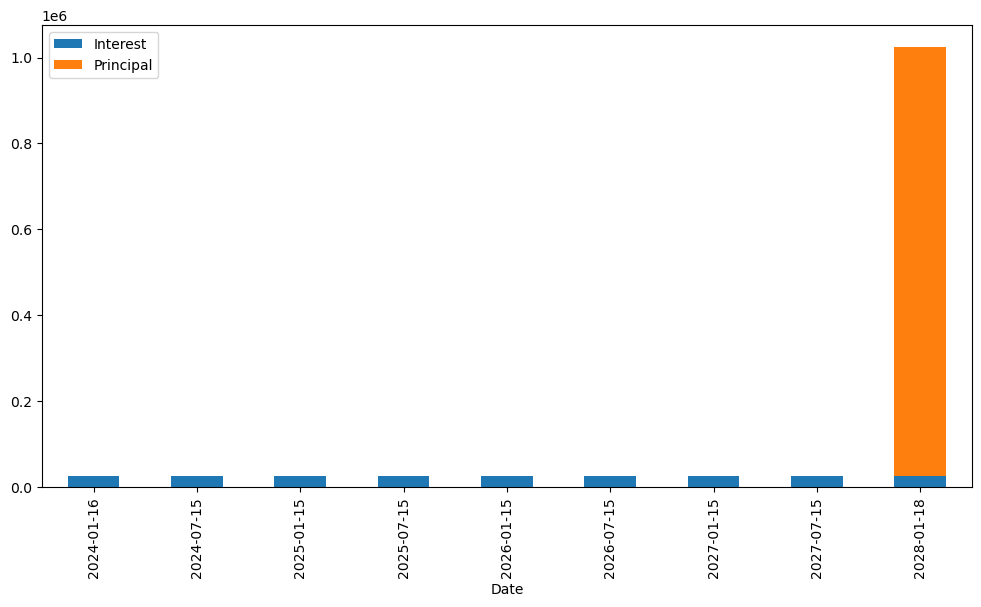

In [9]:
df = bonds_cashflows_dict['BOND_VANILLA_5Y']
display(df)

# Separate principal and interest payments
principal_df = df[df['event'] == 'Principal']
interest_df = df[df['event'] == 'Interest']

# Create a combined dataframe for plotting
plot_data = pd.DataFrame({
    'Date': df['date'].unique(),
    'Interest': df[df['event'] == 'Interest'].groupby('date')['amount'].sum(),
    'Principal': df[df['event'] == 'Principal'].groupby('date')['amount'].sum()
}).fillna(0)

# Create stacked column chart
plot_data.set_index('Date')[['Interest', 'Principal']].plot(kind='bar', stacked=True, figsize=(12, 6))
plt.show()


#### Scenario 2 Cashflows: Linear amortization

,date,amount,remainingNotional,currency,event,type,occurence
0,2024-01-16,22225.57,800000.0,USD,Interest,Fixed,Future
1,2024-01-16,100000.00,800000.0,USD,Principal,Fixed,Future
2,2024-07-15,19756.06,700000.0,USD,Interest,Fixed,Future
3,2024-07-15,100000.00,700000.0,USD,Principal,Fixed,Future
4,2025-01-15,17286.55,600000.0,USD,Interest,Fixed,Future
5,2025-01-15,100000.00,600000.0,USD,Principal,Fixed,Future
6,2025-07-15,14817.05,500000.0,USD,Interest,Fixed,Future
7,2025-07-15,100000.00,500000.0,USD,Principal,Fixed,Future
8,2026-01-15,12347.54,400000.0,USD,Interest,Fixed,Future
9,2026-01-15,100000.00,400000.0,USD,Principal,Fixed,Future


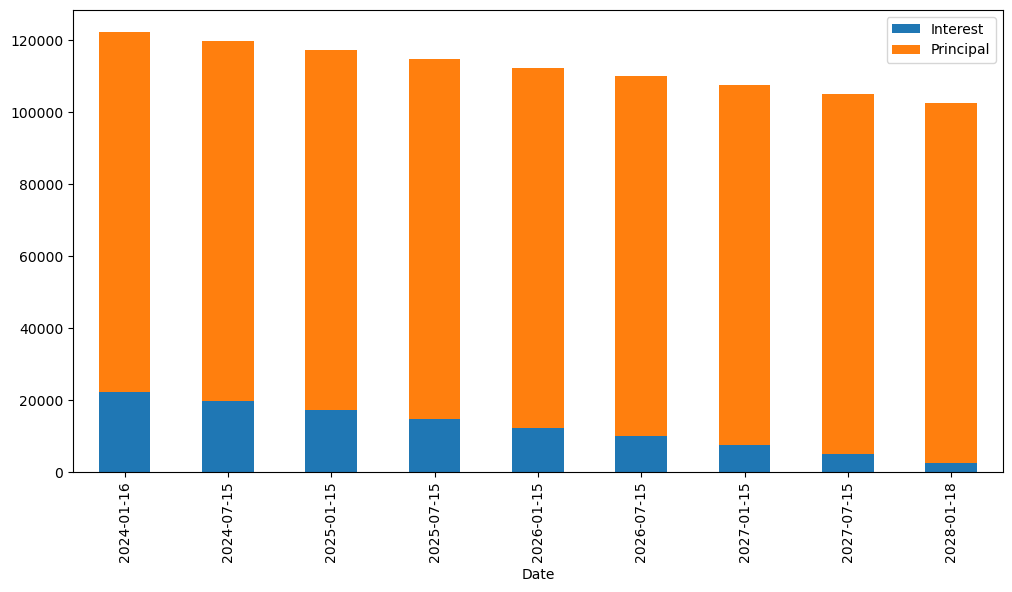

In [10]:
df = bonds_cashflows_dict['BOND_LINEAR_AMORT_5Y']
display(df)

# Separate principal and interest payments
principal_df = df[df['event'] == 'Principal']
interest_df = df[df['event'] == 'Interest']

# Create a combined dataframe for plotting
plot_data = pd.DataFrame({
    'Date': df['date'].unique(),
    'Interest': df[df['event'] == 'Interest'].groupby('date')['amount'].sum(),
    'Principal': df[df['event'] == 'Principal'].groupby('date')['amount'].sum()
}).fillna(0)

# Create stacked column chart
plot_data.set_index('Date')[['Interest', 'Principal']].plot(kind='bar', stacked=True, figsize=(12, 6))
plt.show()

#### Scenario 3 Cashflows: Custom amortization

,date,amount,remainingNotional,currency,event,type,occurence
0,2024-01-16,24695.08,1000000.0,USD,Interest,Fixed,Future
1,2024-07-15,24695.08,1000000.0,USD,Interest,Fixed,Future
2,2025-01-15,24695.08,500000.0,USD,Interest,Fixed,Future
3,2025-01-15,500000.00,500000.0,USD,Principal,Fixed,Future
4,2025-07-15,12347.54,500000.0,USD,Interest,Fixed,Future
5,2026-01-15,12347.54,500000.0,USD,Interest,Fixed,Future
6,2026-07-15,12347.54,500000.0,USD,Interest,Fixed,Future
7,2027-01-15,12347.54,500000.0,USD,Interest,Fixed,Future
8,2027-07-15,12347.54,500000.0,USD,Interest,Fixed,Future
9,2028-01-18,12347.54,0.0,USD,Interest,Fixed,Future


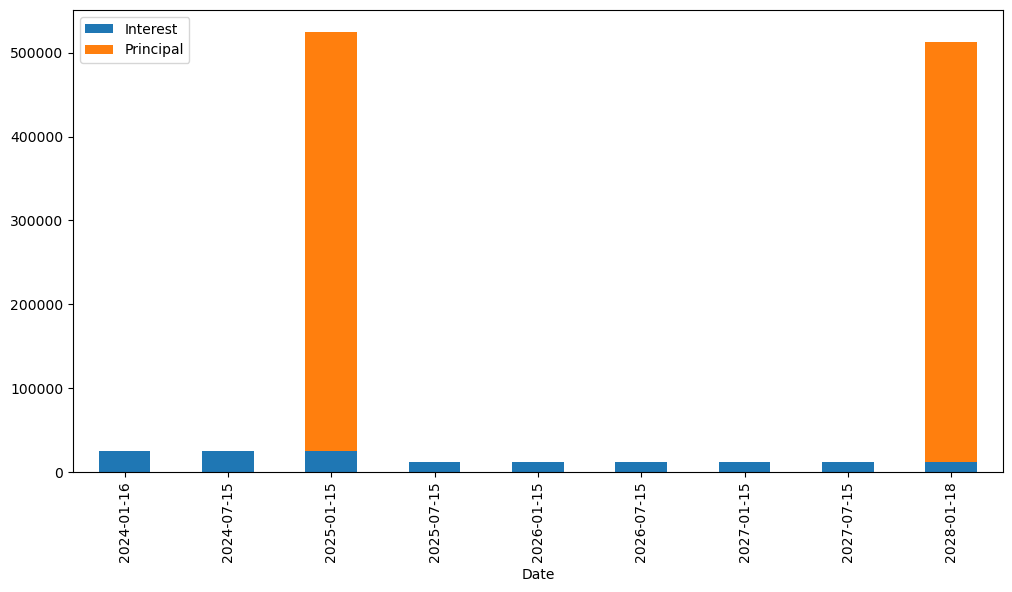

In [11]:
df = bonds_cashflows_dict['BOND_CUSTOM_AMORT_5Y']
display(df)

# Separate principal and interest payments
principal_df = df[df['event'] == 'Principal']
interest_df = df[df['event'] == 'Interest']

# Create a combined dataframe for plotting
plot_data = pd.DataFrame({
    'Date': df['date'].unique(),
    'Interest': df[df['event'] == 'Interest'].groupby('date')['amount'].sum(),
    'Principal': df[df['event'] == 'Principal'].groupby('date')['amount'].sum()
}).fillna(0)

# Create stacked column chart
plot_data.set_index('Date')[['Interest', 'Principal']].plot(kind='bar', stacked=True, figsize=(12, 6))
plt.show()